# Modelo RNA para classificação de números usando RNA com dropout

## Importação de bibliotecas

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers

## MNIST

In [2]:
(train_img, train_lbs), (test_img, test_lbs) = tf.keras.datasets.mnist.load_data() ### Função do TensorFlow para carregar o dataset MNIST - Ela retorna duas tuplas, uma para treino e outra para teste. O par é composto pelas imagens em 28x28 px e as labels que são os valores de 0 a 9.
train_img = train_img.reshape((60000, 28 * 28)).astype('float32') / 255 ### Redimensionamento para 1D e e normalização para o tipo float entre 0 e 1. Etapa para garantir compatibilidade e convergência.
test_img = test_img.reshape((10000, 28 * 28)).astype('float32') / 255   ### Redimensionamento para 1D e e normalização para o tipo float entre 0 e 1. Etapa para garantir compatibilidade e convergência.

train_lbs = tf.keras.utils.to_categorical(train_lbs) ### Aplicação do OneHotEncoding
test_lbs = tf.keras.utils.to_categorical(test_lbs) ### Aplicação do OneHotEncoding

## Ruído

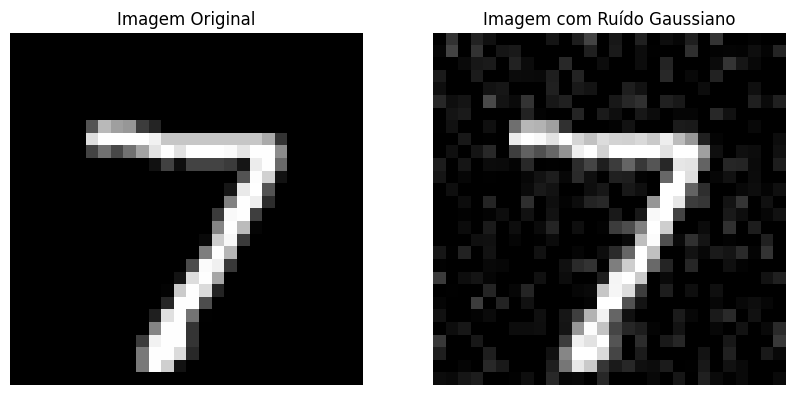

In [3]:
def gaussian_noise(img, mean=0., std=0.1):
    noise = np.random.normal(mean, std, img.shape) ### Função numpy para distribuição normal
    noisy_images = img + noise ### Soma do array da imagem original com o array ruído, gerando um novo array
    noisy_images = np.clip(noisy_images, 0., 1.) ### Aqui os valores do novo array que passam do range 0-1 são corrigidos para seguir a estrutura que definimos anteriormente no MNIST
    return noisy_images

test_img_noisy = gaussian_noise(test_img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_img[0].reshape(28, 28), cmap='gray')
plt.title('Imagem Original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(test_img_noisy[0].reshape(28, 28), cmap='gray')
plt.title('Imagem com Ruído Gaussiano')
plt.axis('off')
plt.show()

## Definindo e Treinando o modelo

In [4]:
dropout = [0.1, 0.2, 0.3, 0.4, 0.5]
results = {}
results_noisy = {}
trained_models = {}
histories = {}

for rate in dropout:
    print(f"Taxa de Dropout: {rate}")
    model = models.Sequential([
        layers.Input(shape=(28*28,)),
        layers.Dense(64, activation='relu'), ### Todos neurônios conectados aos neurônios da camada anterior. Função de ativação ReLU (Unidade Linear Retificada). Retorna o próprio valor de entrada se for positivo, e zero caso contrário
        layers.Dropout(rate), ### Durante o treinamento, ela desativa aleatoriamente uma fração dos neurônios de entrada para esta camada
        layers.Dense(10, activation='softmax') ### Converte saídas brutas dos neurônios em uma distribuição de probabilidade sobre as 10 classes
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_img, train_lbs, epochs=100, batch_size=128, verbose=0, validation_data=(test_img, test_lbs))
    histories[rate] = history.history

    test_loss, test_acc = model.evaluate(test_img, test_lbs, verbose=0)
    print(f'Acurácia de teste com Taxa de Dropout {rate}: {test_acc:.4f}')
    results[rate] = {'accuracy' : test_acc, 'loss':test_loss}

    test_loss_noisy, test_acc_noisy = model.evaluate(test_img_noisy, test_lbs, verbose=0)
    print(f'Acurácia de teste (com ruído) com Taxa de Dropout {rate}: {test_acc_noisy:.4f}')
    results_noisy[rate] = {'accuracy' : test_acc_noisy, 'loss':test_loss_noisy}

    trained_models[rate] = model



Taxa de Dropout: 0.1
Acurácia de teste com Taxa de Dropout 0.1: 0.9760
Acurácia de teste (com ruído) com Taxa de Dropout 0.1: 0.9275
Taxa de Dropout: 0.2
Acurácia de teste com Taxa de Dropout 0.2: 0.9736
Acurácia de teste (com ruído) com Taxa de Dropout 0.2: 0.9299
Taxa de Dropout: 0.3
Acurácia de teste com Taxa de Dropout 0.3: 0.9744
Acurácia de teste (com ruído) com Taxa de Dropout 0.3: 0.9213
Taxa de Dropout: 0.4
Acurácia de teste com Taxa de Dropout 0.4: 0.9718
Acurácia de teste (com ruído) com Taxa de Dropout 0.4: 0.8938
Taxa de Dropout: 0.5
Acurácia de teste com Taxa de Dropout 0.5: 0.9720
Acurácia de teste (com ruído) com Taxa de Dropout 0.5: 0.8867


## Visualizando

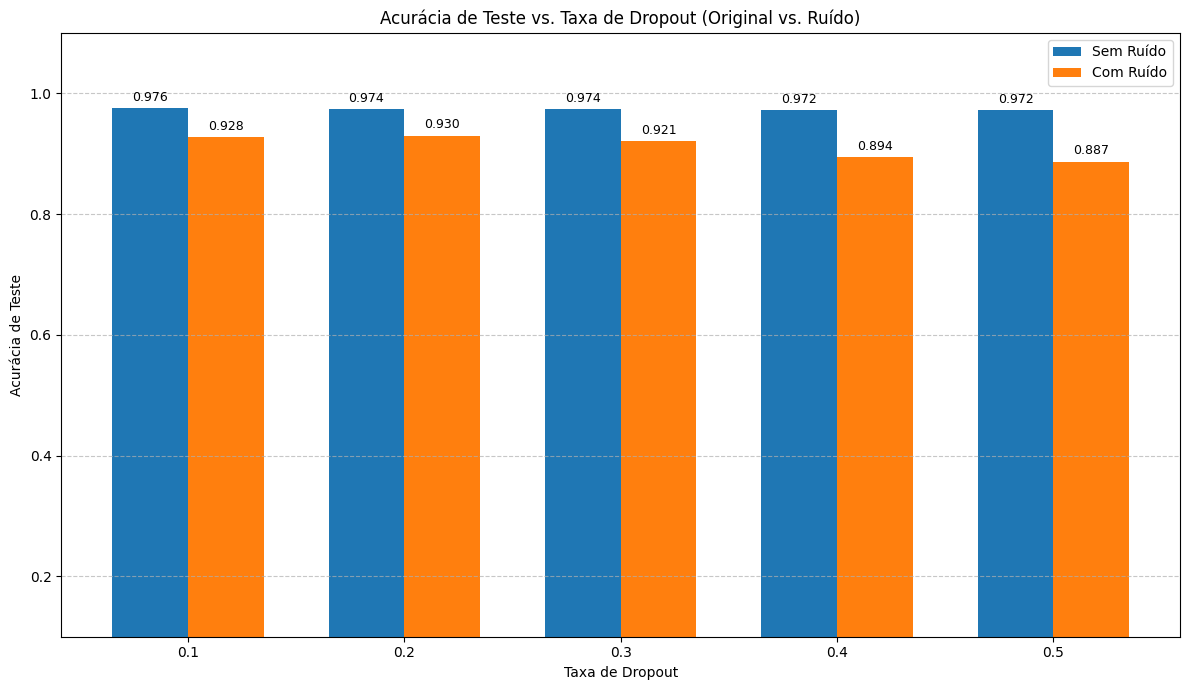

In [5]:
dropout_rates = list(results.keys())
accuracies_original = [v['accuracy'] for v in results.values()]
accuracies_noisy = [v['accuracy'] for v in results_noisy.values()]

x = np.arange(len(dropout_rates))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, accuracies_original, width, label='Sem Ruído')
rects2 = ax.bar(x + width/2, accuracies_noisy, width, label='Com Ruído')

ax.set_xlabel('Taxa de Dropout')
ax.set_ylabel('Acurácia de Teste')
ax.set_title('Acurácia de Teste vs. Taxa de Dropout (Original vs. Ruído)')
ax.set_xticks(x)
ax.set_xticklabels([str(r) for r in dropout_rates])
ax.set_ylim(0.1, 1.1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)


for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

fig.tight_layout()
plt.show()


In [6]:
rates = list(histories.keys())
rates

[0.1, 0.2, 0.3, 0.4, 0.5]

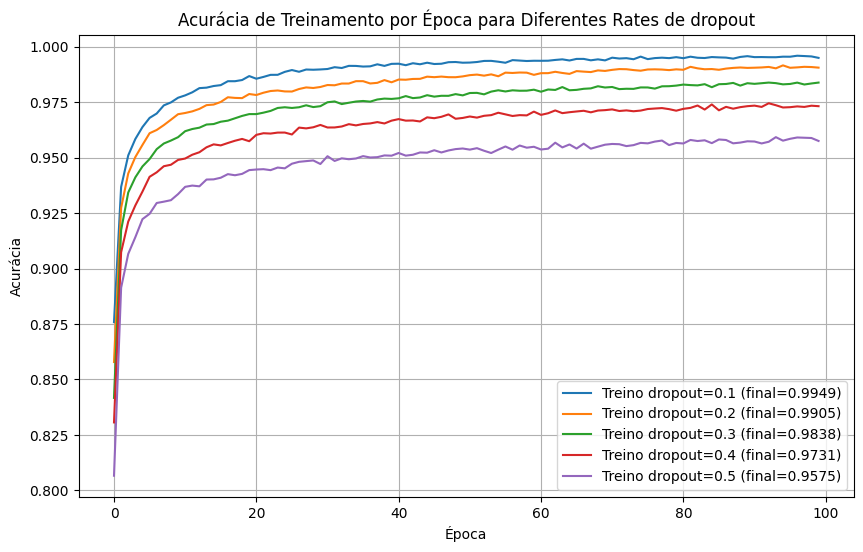

In [8]:
rates = list(histories.keys())
accuracies_original1 = [v['accuracy'] for v in histories.values()]
accuracies_teste1 = [v['val_accuracy'] for v in histories.values()]

plt.figure(figsize=(10, 6))

for i, rate in zip(accuracies_original1, rates):
    final = i[-1]
    plt.plot(i, label=f'Treino dropout={rate} (final={final:.4f})')

plt.title('Acurácia de Treinamento por Época para Diferentes Rates de dropout')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()



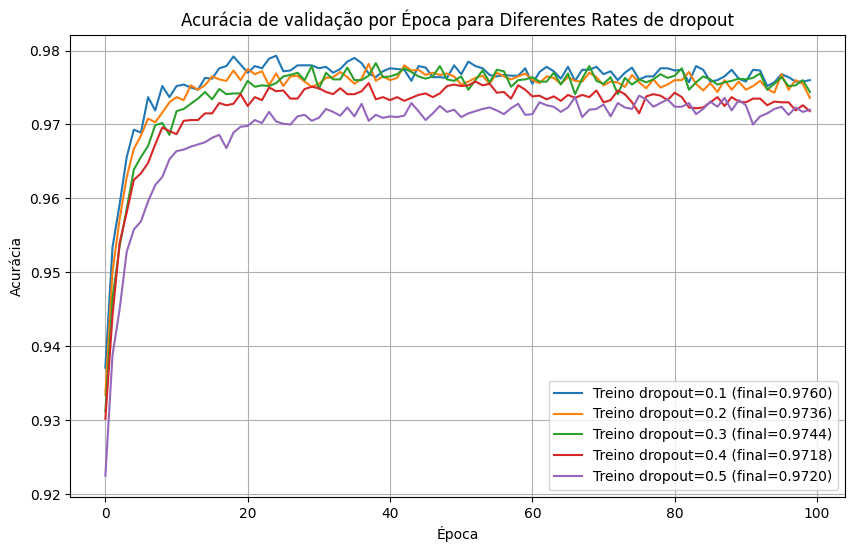

In [10]:
plt.figure(figsize=(10, 6))

for i, rate in zip(accuracies_teste1, rates):
    final = i[-1]
    plt.plot(i, label=f'Treino dropout={rate} (final={final:.4f})')

plt.title('Acurácia de validação por Época para Diferentes Rates de dropout')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

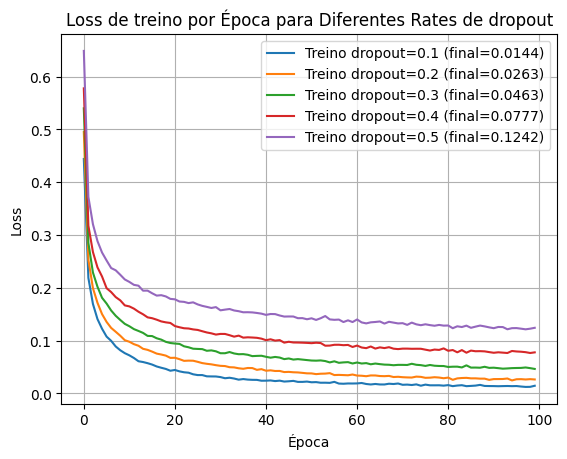

In [11]:
loss_original1 = [v['loss'] for v in histories.values()]
loss_teste1 = [v['val_loss'] for v in histories.values()]

for i, rate in zip(loss_original1, rates):
    final = i[-1]
    plt.plot(i, label=f'Treino dropout={rate} (final={final:.4f})')

plt.title('Loss de treino por Época para Diferentes Rates de dropout')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

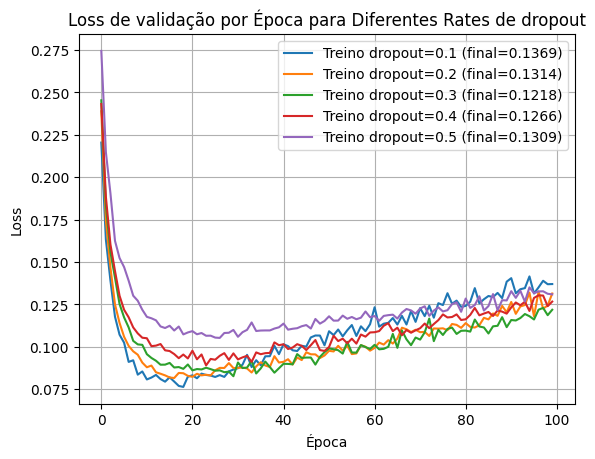

In [13]:
for i, rate in zip(loss_teste1, rates):
    final = i[-1]
    plt.plot(i, label=f'Treino dropout={rate} (final={final:.4f})')

plt.title('Loss de validação por Época para Diferentes Rates de dropout')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = np.argmax(test_lbs, axis=1)
y_true

array([7, 2, 1, ..., 4, 5, 6], shape=(10000,))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


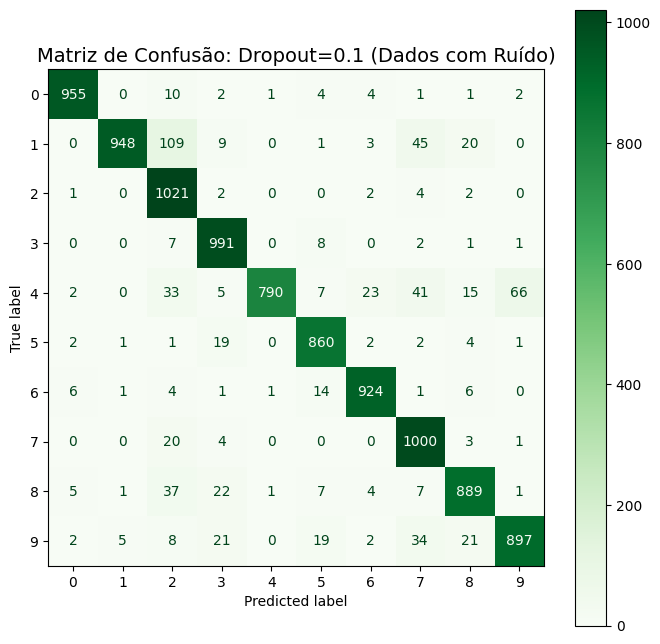

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       980
           1       0.99      0.84      0.91      1135
           2       0.82      0.99      0.89      1032
           3       0.92      0.98      0.95      1010
           4       1.00      0.80      0.89       982
           5       0.93      0.96      0.95       892
           6       0.96      0.96      0.96       958
           7       0.88      0.97      0.92      1028
           8       0.92      0.91      0.92       974
           9       0.93      0.89      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


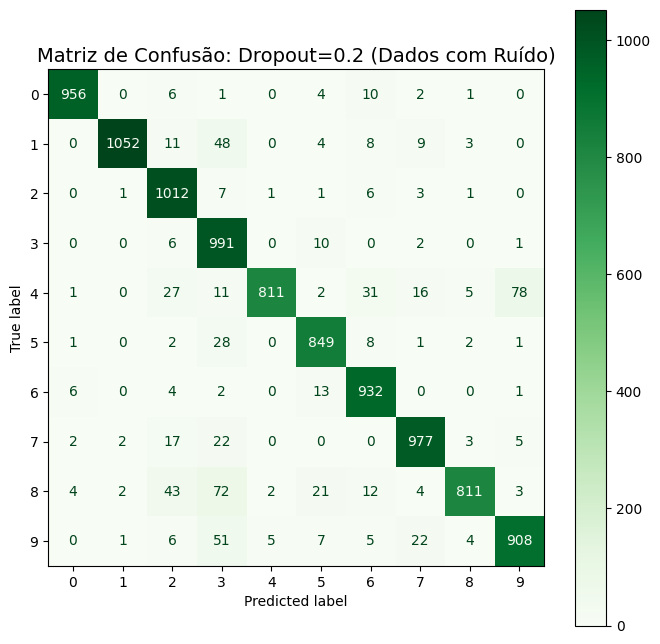

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.99      0.93      0.96      1135
           2       0.89      0.98      0.93      1032
           3       0.80      0.98      0.88      1010
           4       0.99      0.83      0.90       982
           5       0.93      0.95      0.94       892
           6       0.92      0.97      0.95       958
           7       0.94      0.95      0.95      1028
           8       0.98      0.83      0.90       974
           9       0.91      0.90      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.94      0.93      0.93     10000
weighted avg       0.94      0.93      0.93     10000

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


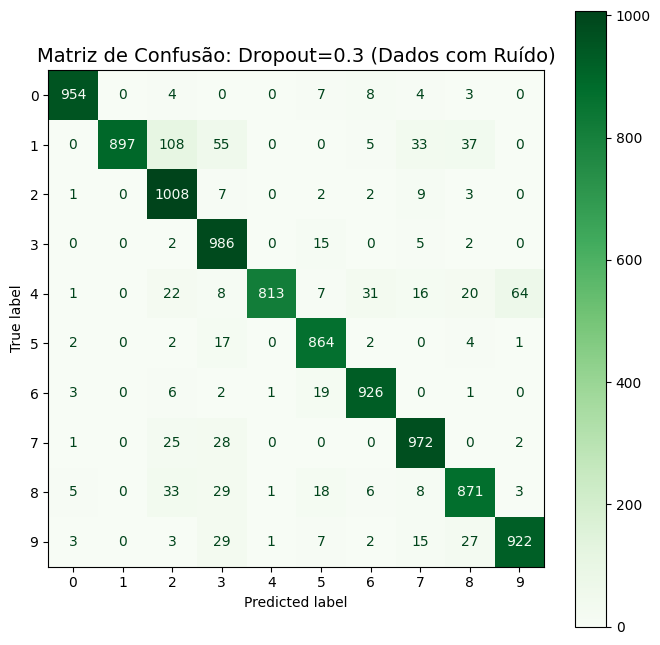

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       980
           1       1.00      0.79      0.88      1135
           2       0.83      0.98      0.90      1032
           3       0.85      0.98      0.91      1010
           4       1.00      0.83      0.90       982
           5       0.92      0.97      0.94       892
           6       0.94      0.97      0.95       958
           7       0.92      0.95      0.93      1028
           8       0.90      0.89      0.90       974
           9       0.93      0.91      0.92      1009

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


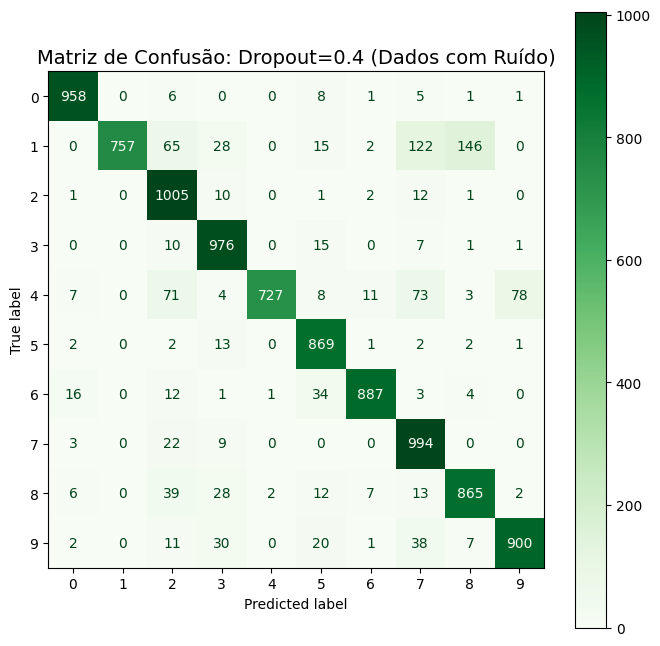

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       1.00      0.67      0.80      1135
           2       0.81      0.97      0.88      1032
           3       0.89      0.97      0.93      1010
           4       1.00      0.74      0.85       982
           5       0.88      0.97      0.93       892
           6       0.97      0.93      0.95       958
           7       0.78      0.97      0.87      1028
           8       0.84      0.89      0.86       974
           9       0.92      0.89      0.90      1009

    accuracy                           0.89     10000
   macro avg       0.91      0.90      0.89     10000
weighted avg       0.91      0.89      0.89     10000

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


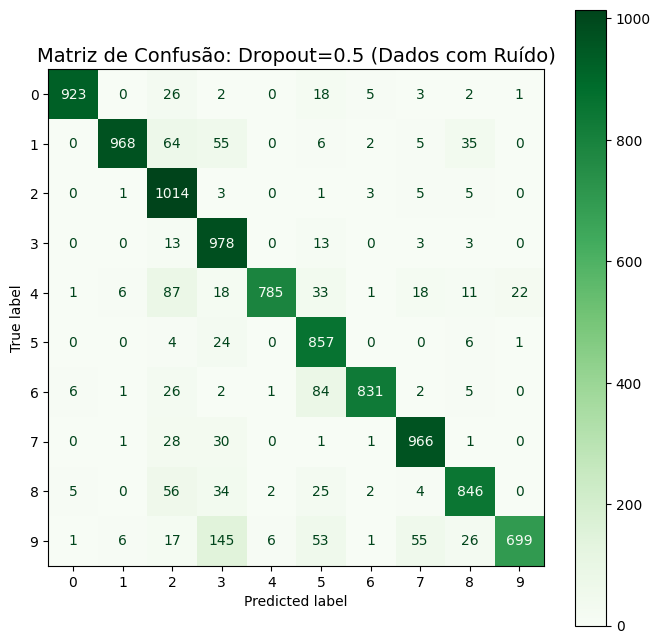

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       980
           1       0.98      0.85      0.91      1135
           2       0.76      0.98      0.86      1032
           3       0.76      0.97      0.85      1010
           4       0.99      0.80      0.88       982
           5       0.79      0.96      0.86       892
           6       0.98      0.87      0.92       958
           7       0.91      0.94      0.92      1028
           8       0.90      0.87      0.88       974
           9       0.97      0.69      0.81      1009

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



In [15]:
for dropout_rate, model_obj in trained_models.items():
    probabilities = model_obj.predict(test_img_noisy)
    y_pred = np.argmax(probabilities, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    class_names = np.unique(y_true)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Greens, ax=ax)
    ax.set_title(f'Matriz de Confusão: Dropout={dropout_rate} (Dados com Ruído)', fontsize=14)
    plt.show()

    print(classification_report(y_true, y_pred))